-----------------
1. 训练前准备
    1. 指定训练的设备
    1. 准备训练用的数据集和模型
1. 通过 paddle.Model 高层 API 训练与评估验证
    1. 使用 paddle.Model 封装模型
    1. 使用 Model.prepare 配置训练准备参数
        1. 损失函数
        1. 优化器
        1. 评价指标
    1. 使用 Model.fit 训练模型
    1. 使用 Model.evaluate 评估模型
    1. 使用 Model.predict 执行推理
    
1. 通过基础 API 训练与评估验证
    1. 模型训练（拆解 Model.prepare、Model.fit）
    1. 模型评估（拆解 Model.evaluate）
    1. 模型推理（拆解 Model.predict）

1. 扩展阅读：恢复训练---补FAQ，并在本文加引用
1. 扩展阅读：欠拟合和过拟合---补FAQ，并在本文加引用
1. 扩展阅读：自定义LOSS、Metric、Callback，优化器不能自定义？自定义哪些东西的界限怎么划的？
1. 扩展阅读：训练过程可视化分析---独立一篇并在本文加引用


# 模型训练、评估与推理

在完成数据预处理，数据加载与模型的组建后，你就可以进行模型的训练与推理了。训练时通过很多个循环（epoch）训练模型，每轮会将输入数据传入定义好的模型，得到预测值。预测值将与label做loss，然后loss进行反向传播，之后再通过优化器优化网络的参数。推理时只需要将数据输入训练好的网络，得到预测值。飞桨主框架提供了两种训练与推理的方法，一种是用 [paddle.Model](../api/paddle/Model_cn.html) 对模型进行封装，通过高层API如 [Model.fit](../api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none) 、 [Model.evaluate](../api/paddle/Model_cn.html#evaluate-eval-data-batch-size-1-log-freq-10-verbose-2-num-workers-0-callbacks-none) 、 [Model.predict](../api/paddle/Model_cn.html#predict-test-data-batch-size-1-num-workers-0-stack-outputs-false-callbacks-none) 等完成模型的训练、评估与推理；另一种就是基于基础API常规的训练方式。通过高层API完成模型的训练、评估与推理，可以省略很多复杂的步骤，适合新手上手，但是各个参数必须符合API的格式；另一种就是基于基础API常规的训练方式，这种方法比较灵活，但是需要实现训练中所有的步骤设定所有的流程。

高层API实现的模型训练、评估与推理如 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 都可以通过基础API实现，本文先介绍高层API的训练方式，然后会将高层API拆解为基础API的方式，方便对比学习。



## 一、训练前准备

开始之前，需要使用下面的命令安装 Python 的 matplotlib 库和 numpy 库，matplotlib 库用于可视化图片，numpy 库用于处理数据。

In [ ]:
# 使用 pip 工具安装 matplotlib 和 numpy
! python3 -m pip install matplotlib numpy -i https://mirror.baidu.com/pypi/simple

### 1.1 指定训练的硬件

模型训练时，需要用到 CPU、 GPU 等计算处理器资源，由于飞桨框架的安装包是区分处理器类型的，默认情况下飞桨框架会根据所安装的版本自动选择对应硬件，比如安装的 GPU 版本的飞桨，则自动使用 GPU 训练模型，无需手动指定。

但是如果安装的 GPU 版本的飞桨框架，想切换到 CPU 上训练，则可通过 [paddle.device.set_device](../api/paddle/device/set_device_cn.html#set-device) API 修改，如果本机有多个 GPU 卡，也可以通过该 API 选择指定的卡进行训练。

In [3]:
import paddle
import numpy as np
from paddle.vision.transforms import ToTensor

# 指定在 CPU 上训练
paddle.device.set_device('cpu')

# 指定在 GPU 第 0 号卡上训练
# paddle.device.set_device('gpu:0')

CPUPlace

> * 本文仅以单机单卡场景为例，介绍模型训练的方法，如果需要使用单机多卡、多机多卡训练，请参考如下章节：[单机多卡训练](06_device_cn.html)、[分布式训练](./06_distributed_training/distributed_introduction.html)。
> * 飞桨框架除了支持在 CPU、GPU 上训练，还支持在百度昆仑 XPU、华为昇腾 NPU 等 AI 计算处理器上训练，对应的训练指导请参考 [硬件支持](./09_hardware_support/index_cn.html) 章节。
> * 注意使用 `paddle.device.set_device` 时，只能指定CUDA_VISIBLE_DEVICES可见的显卡，例如同时设置 `CUDA_VISIBLE_DEVICES=1` 和 `paddle.device.set_device('gpu:0')` 时会冲突报错

### 1.2 准备训练用的数据集和模型

模型训练前，需要先完成数据集的加载和模型组网，以 MNIST 手写数字识别任务为例，代码示例如下：

In [5]:

# 加载 MNIST 训练集和测试集
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())

# 使用 Sequential 进行模型组网
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(1, -1), 
    paddle.nn.Linear(784, 512), 
    paddle.nn.ReLU(), 
    paddle.nn.Dropout(0.2), 
    paddle.nn.Linear(512, 10)
)



## 二、通过 paddle.Model 高层 API 训练、评估与推理


以手写数字识别任务为例，使用高层 API 进行模型训练、评估与推理的步骤如下：


### 2.1 使用 paddle.Model 封装模型

使用高层 API 训练模型前，可使用 [paddle.Model](../api/paddle/Model_cn.html) 将模型封装为一个实例，方便后续进行训练、评估与推理。代码如下：

In [6]:
# 封装模型，便于进行后续的训练、评估和推理
model = paddle.Model(mnist)

### 2.2 使用 Model.prepare 配置训练准备参数

用 `paddle.Model` 完成模型的封装后，在训练前，需要对模型进行配置，通过 [Model.prepare](../api/paddle/Model_cn.html#prepare-optimizer-none-loss-none-metrics-none-amp-configs-none) 接口来对训练进行提前的配置准备工作，包括设置模型优化器，Loss计算方法，精度计算方法等。

* 优化器（optimizer）用于计算和更新梯度，优化器能够保存参数状态并根据梯度更新传入优化器的参数，这里我们使用常用的Adam优化器 `paddle.optimizer.Adam` ，并传入封装好的模型全部参数 `model.parameters` 。更多优化器API详见 [paddle.optimizer](../api/paddle/optimizer/Overview_cn.html#paddle-optimizer)；
* 损失函数（loss）用来评价模型的预测值和真实值不一样的程度，在这里我们使用交叉熵损失函数 `paddle.nn.CrossEntropyLoss` 。更多Loss API详见 [Loss层](../api/paddle/nn/Overview_cn.html#loss-layers)；
* 评价指标（metrics）用于评估模型的好坏，不同的任务通常有不同的评价指标，本任务中我们使用分类任务常用的准确率指标 `paddle.metric.Accuracy` 。更多评估器API详见 [paddle.metric](../api/paddle/metric/Overview_cn.html)。


In [7]:
# 为模型训练做准备，设置优化器并将网络的参数传入优化器，设置损失函数和精度计算方式
model.prepare(optimizer=paddle.optimizer.Adam(parameters=model.parameters()), 
              loss=paddle.nn.CrossEntropyLoss(), 
              metrics=paddle.metric.Accuracy())

### 2.3 使用 Model.fit 训练模型

做好模型训练的前期准备工作后，调用 [Model.fit](../api/paddle/Model_cn.html#fit-train-data-none-eval-data-none-batch-size-1-epochs-1-eval-freq-1-log-freq-10-save-dir-none-save-freq-1-verbose-2-drop-last-false-shuffle-true-num-workers-0-callbacks-none) 接口来启动训练过程，需要指定至少3个关键参数：训练数据集，训练轮次和单次训练数据批次大小:

* 训练数据集：传入之前定义好的训练数据集；
* 训练轮次（epoch）：训练时遍历数据集的次数；
* 批次大小（batch_size）：通常情况下，数据集需要分批读取训练，设定每个批次数据的大小。

除此之外，还可以传入 `Callback` 参数，这个参数可以在模型训练的各个阶段进行一些自定义操作，详见第7章。


In [8]:
# 启动模型训练，指定训练数据集，设置训练轮次，设置每次数据集计算的批次大小，设置日志格式
model.fit(train_dataset, 
          epochs=5, 
          batch_size=64,
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/5


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


step 938/938 [==============================] - loss: 0.1962 - acc: 0.9300 - 29ms/step          
Epoch 2/5
step 938/938 [==============================] - loss: 0.0445 - acc: 0.9689 - 29ms/step          
Epoch 3/5
step 938/938 [==============================] - loss: 0.0638 - acc: 0.9780 - 29ms/step          
Epoch 4/5
step 938/938 [==============================] - loss: 0.0035 - acc: 0.9825 - 29ms/step          
Epoch 5/5
step 938/938 [==============================] - loss: 0.0786 - acc: 0.9860 - 33ms/step          


### 2.4 使用 Model.evaluate 评估模型

对于训练好的模型进行评估可以使用 [Model.evaluate](../api/paddle/Model_cn.html#evaluate-eval-data-batch-size-1-log-freq-10-verbose-2-num-workers-0-callbacks-none) 接口，事先定义好用于评估使用的数据集后，直接调用 `evaluate` 接口即可完成模型评估操作，结束后根据在 `prepare` 中 `loss` 和 `metric` 的定义来进行相关评估结果计算返回。

返回格式是一个字典:
* 只包含loss， `{'loss': xxx}` 
* 包含loss和一个评估指标， `{'loss': xxx, 'metric name': xxx}` 
* 包含loss和多个评估指标， `{'loss': xxx, 'metric name1': xxx, 'metric name2': xxx}` 

In [9]:
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(test_dataset, verbose=1)
print(eval_result)

Eval begin...
step 10000/10000 [==============================] - loss: 3.5763e-07 - acc: 0.9810 - 3ms/step          
Eval samples: 10000
{'loss': [3.5762793e-07], 'acc': 0.981}


### 2.5 使用 Model.predict 执行推理

高层API中提供了 [Model.predict](../api/paddle/Model_cn.html#predict-test-data-batch-size-1-num-workers-0-stack-outputs-false-callbacks-none) 接口来方便用户对训练好的模型进行推理验证，只需要基于训练好的模型将需要进行推理验证的数据放到接口中进行计算即可，接口会将经过模型计算得到的预测结果进行返回。

返回格式是一个list，元素数目对应模型的输出数目：
* 模型是单一输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n)]`
* 模型是多输出：`[(numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), (numpy_ndarray_1, numpy_ndarray_2, …, numpy_ndarray_n), …]`

numpy_ndarray_n是对应原始数据经过模型计算后得到的预测数据，数目对应预测数据集的数目。




Predict begin...
step 10000/10000 [==============================] - 2ms/step          
Predict samples: 10000
[[ -6.5593615  -6.4680595  -1.4708003   2.1043894 -11.743436   -4.4516582
  -14.733968   12.036645   -6.582403   -1.8672216]]
true label: 7, pred label: 7


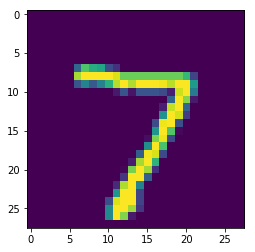

In [19]:
# 用 predict 在测试集上对模型进行推理
test_result = model.predict(test_dataset)
# 由于模型是单一输出，test_result的形状为[1, 10000]，10000是测试数据集的数据量。这里打印第一个数据的结果，这个数组表示每个数字的预测概率
print(test_result[0][0])

# 从测试集中取出一张图片
img, label = test_dataset[0]

# 执行推理并打印结果，这里的argmax函数用于取出预测值中概率最高的一个的下标，作为预测标签
pred_label = test_result[0][0].argmax()
print('true label: {}, pred label: {}'.format(label[0], pred_label))
# 使用matplotlib库，可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0])

### 2.6 其他高层API

除了上面介绍的三个API之外， `paddle.Model` 类也提供了其他与训练、评估与推理相关的API：

* [Model.train_batch](../api/paddle/Model_cn.html#train-batch-inputs-labels-none)：在一个批次的数据集上进行训练；
* [Model.eval_batch](../api/paddle/Model_cn.html#eval-batch-inputs-labels-none)：在一个批次的数据集上进行评估；
* [Model.predict_batch](../api/paddle/Model_cn.html#predict-batch-inputs)：在一个批次的数据集上进行推理。

这三个API与上面介绍的三个API的输入数据的维度有所不同，需要用户在实际应用场景进行判断使用。

## 三、通过基础 API 训练与评估验证

除了通过第一部分的高层API实现模型的训练与预测，飞桨框架也同样支持通过基础API对模型进行训练与预测。简单来说， `Model.prepare` 、 `Model.fit` 、 `Model.evaluate` 、 `Model.predict` 都是由基础API封装而来。下面通过拆解高层API到基础API的方式，来了解如何用基础API完成模型的训练与预测。

（待补充：高层API实现不了的功能）

In [7]:
# 定义网络结构(采用 SubClass 组网)
class Mnist(paddle.nn.Layer):
    def __init__(self):
        super(Mnist, self).__init__()
        self.flatten = paddle.nn.Flatten()
        self.linear_1 = paddle.nn.Linear(784, 512)
        self.linear_2 = paddle.nn.Linear(512, 10)
        self.relu = paddle.nn.ReLU()
        self.dropout = paddle.nn.Dropout(0.2)
            
    def forward(self, inputs):
        y = self.flatten(inputs)
        y = self.linear_1(y)
        y = self.relu(y)
        y = self.dropout(y)
        y = self.linear_2(y)
        return y

### 3.1 模型训练（拆解 Model.prepare、Model.fit）

飞桨框架通过基础API对模型进行训练，对应第一部分的 `Model.prepare` 与 `Model.fit` 。模型训练一般包括如下几个步骤：

1. 加载训练数据集、声明模型、设置模型为 `train` 模式
1. 设置优化器、损失函数与各个超参数
1. 从DataLoader获取一批次训练数据
1. 执行一次预测，即从模型获得输入数据的预测值
1. 计算预测值与数据集标签的损失
1. 计算预测值与数据集标签的准确率
1. 将损失进行反向传播
1. 打印模型的轮数、批次、损失值、准确率等信息
1. 执行一次优化器步骤，也就是根据我们选择的优化算法，根据当前批次数据的梯度更新传入优化器的参数
1. 将优化器的梯度进行清零
    


In [8]:
# dataset与mnist的定义与使用高层API的内容一致
# 用 DataLoader 实现数据加载
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True)

# 声明Mnist类的一个实例
mnist=Mnist()
# 将此层及其所有子层设置为训练模式。这只会影响某些模块，如Dropout和BatchNorm。
mnist.train()

# 设置迭代次数
epochs = 5

# 设置优化器
optim = paddle.optimizer.Adam(parameters=mnist.parameters())
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
        
        x_data = data[0]            # 训练数据
        y_data = data[1]            # 训练数据标签
        predicts = mnist(x_data)    # 预测结果  
        
        # 计算损失 等价于 prepare 中loss的设置
        loss = loss_fn(predicts, y_data)
        
        # 计算准确率 等价于 prepare 中metrics的设置
        acc = paddle.metric.accuracy(predicts, y_data)
        
        # 下面的反向传播、打印训练信息、更新参数、梯度清零都被封装到 Model.fit() 中
        # 反向传播 
        loss.backward()
        
        if (batch_id+1) % 900 == 0:
            print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id+1, loss.numpy(), acc.numpy()))
        # 更新参数 
        optim.step()
        # 梯度清零
        optim.clear_grad()

epoch: 0, batch_id: 900, loss is: [0.03877499], acc is: [1.]
epoch: 1, batch_id: 900, loss is: [0.04977579], acc is: [0.984375]
epoch: 2, batch_id: 900, loss is: [0.01578258], acc is: [1.]
epoch: 3, batch_id: 900, loss is: [0.10209924], acc is: [0.96875]
epoch: 4, batch_id: 900, loss is: [0.04281481], acc is: [1.]


### 3.2 模型评估（拆解 Model.evaluate）

飞桨框架通过基础API对模型进行验证，对应第一部分的 `Model.evaluate` 。与模型训练相比，模型评估的流程有如下几点不同之处：

* 加载的数据从训练数据集改为测试数据集
* 模型实例从 `train` 模式改为 `eval` 模式
* 不需要反向传播、优化器参数更新和优化器梯度清零



In [9]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 设置损失函数
loss_fn = paddle.nn.CrossEntropyLoss()
# 将该模型及其所有子层设置为预测模式。这只会影响某些模块，如Dropout和BatchNorm
mnist.eval()
# 禁用动态图梯度计算
for batch_id, data in enumerate(test_loader()):
    
    x_data = data[0]            # 测试数据
    y_data = data[1]            # 测试数据标签
    predicts = mnist(x_data)    # 预测结果
    
    # 计算损失与精度
    loss = loss_fn(predicts, y_data)
    acc = paddle.metric.accuracy(predicts, y_data)
    
    # 打印信息
    if (batch_id+1) % 30 == 0:
        print("batch_id: {}, loss is: {}, acc is: {}".format(batch_id+1, loss.numpy(), acc.numpy()))

batch_id: 30, loss is: [0.12935154], acc is: [0.953125]
batch_id: 60, loss is: [0.19010888], acc is: [0.921875]
batch_id: 90, loss is: [0.07307276], acc is: [0.984375]
batch_id: 120, loss is: [0.01087341], acc is: [1.]
batch_id: 150, loss is: [0.11148524], acc is: [0.984375]


### 3.3 模型推理（拆解 Model.predict）

飞桨框架通过基础API对模型进行推理，对应第一部分的 `Model.predict` 。模型的推理过程相对独立，是在模型训练与评估之后单独进行的步骤。只需要执行如下步骤：

* 加载测试数据集，并将模型设置为 `eval` 模式
* 读取测试数据并获得预测结果
* 对预测结果进行后处理

predict finished
true label: 7, pred label: 7


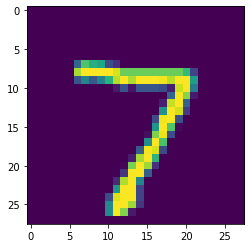

In [10]:
# 加载测试数据集
test_loader = paddle.io.DataLoader(test_dataset, batch_size=64, drop_last=True)
# 将该模型及其所有子层设置为预测模式
mnist.eval()
for batch_id, data in enumerate(test_loader()):
    # 取出测试数据
    x_data = data[0] 
    # 获取预测结果
    predicts = mnist(x_data)
print("predict finished")

# 从测试集中取出一组数据
img, label = test_loader().next()

# 执行推理并打印结果
pred_label = mnist(img)[0].argmax()
print('true label: {}, pred label: {}'.format(label[0].item(), pred_label[0].item()))
# 可视化图片
from matplotlib import pyplot as plt
plt.imshow(img[0][0])

# 四、总结

待补充